In [ ]:
# %%

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox, yeojohnson
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# %%

train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

train_data["time"] = pd.to_datetime(train_data["time"], utc=True)
test_data["time"] = pd.to_datetime(test_data["time"], utc=True)

In [ ]:
# %%

train_data

,time,temp,dwpt,rhum,snow,wdir,wspd,wpgt,pres,price,demand
0,2021-08-31 21:00:00+00:00,11.2,10.3,94.0,NaN,320.0,7.2,16.7,1012.6,0.09016,0.577
1,2021-08-31 22:00:00+00:00,10.7,9.6,93.0,NaN,320.0,7.2,13.0,1012.6,0.09251,0.594
2,2021-08-31 23:00:00+00:00,9.9,9.0,94.0,NaN,320.0,7.2,13.0,1012.2,0.08890,0.685
3,2021-09-01 00:00:00+00:00,10.0,8.4,90.0,NaN,330.0,7.2,13.0,1011.9,0.08735,1.016
4,2021-09-01 01:00:00+00:00,9.0,8.1,94.0,NaN,300.0,3.6,13.0,1011.4,0.08688,0.677
...,...,...,...,...,...,...,...,...,...,...,...
8419,2022-08-17 16:00:00+00:00,26.1,16.1,54.0,NaN,120.0,7.0,13.0,1015.0,0.75008,0.897
8420,2022-08-17 17:00:00+00:00,24.1,16.1,61.0,NaN,100.0,6.0,14.8,1015.0,0.75005,2.796
8421,2022-08-17 18:00:00+00:00,24.1,16.6,63.0,NaN,90.0,4.0,13.0,1015.5,0.74888,0.733
8422,2022-08-17 19:00:00+00:00,20.1,16.1,78.0,NaN,130.0,2.0,13.0,1016.0,0.62909,1.490


In [ ]:
# %%

time_period_start = train_data["time"].min()
time_period_end = train_data["time"].max()

time_period_start, time_period_end, train_data["time"].dt.year.value_counts()

(Timestamp('2021-08-31 21:00:00+0000', tz='UTC'),
 Timestamp('2022-08-17 20:00:00+0000', tz='UTC'),
 time
 2022    5493
 2021    2931
 Name: count, dtype: int64)

In [ ]:
# %%

test_data

,time,temp,dwpt,rhum,snow,wdir,wspd,wpgt,pres,price,demand
0,2022-08-17 21:00:00+00:00,19.1,15.2,78.0,NaN,123.0,5.5,11.1,1016.0,0.50926,0.245
1,2022-08-17 22:00:00+00:00,18.1,15.2,83.0,NaN,97.0,5.5,13.0,1016.0,0.51134,0.178
2,2022-08-17 23:00:00+00:00,18.1,15.2,83.0,NaN,95.0,3.7,11.1,1016.0,0.47990,0.203
3,2022-08-18 00:00:00+00:00,16.7,15.7,94.0,NaN,350.0,0.0,11.1,1016.5,0.42430,0.215
4,2022-08-18 01:00:00+00:00,17.1,15.1,88.0,NaN,90.0,2.0,9.3,1016.0,0.32401,1.043
...,...,...,...,...,...,...,...,...,...,...,...
163,2022-08-24 16:00:00+00:00,27.1,17.0,54.0,NaN,180.0,4.0,11.1,1020.0,0.53494,0.678
164,2022-08-24 17:00:00+00:00,25.1,17.1,61.0,NaN,220.0,6.0,11.1,1021.0,0.49990,0.457
165,2022-08-24 18:00:00+00:00,24.9,18.1,66.0,NaN,150.0,4.0,9.3,1020.9,0.43149,0.500
166,2022-08-24 19:00:00+00:00,22.1,17.0,73.0,NaN,160.0,6.0,9.3,1021.0,0.55203,2.321


In [ ]:
# %%

time_period_start = test_data["time"].min()
time_period_end = test_data["time"].max()

time_period_start, time_period_end, test_data["time"].dt.year.value_counts()

(Timestamp('2022-08-17 21:00:00+0000', tz='UTC'),
 Timestamp('2022-08-24 20:00:00+0000', tz='UTC'),
 time
 2022    168
 Name: count, dtype: int64)

In [ ]:
# %%

train_data.set_index("time", inplace=True)
train_data

,temp,dwpt,rhum,snow,wdir,wspd,wpgt,pres,price,demand
time,,,,,,,,,,
2021-08-31 21:00:00+00:00,11.2,10.3,94.0,NaN,320.0,7.2,16.7,1012.6,0.09016,0.577
2021-08-31 22:00:00+00:00,10.7,9.6,93.0,NaN,320.0,7.2,13.0,1012.6,0.09251,0.594
2021-08-31 23:00:00+00:00,9.9,9.0,94.0,NaN,320.0,7.2,13.0,1012.2,0.08890,0.685
2021-09-01 00:00:00+00:00,10.0,8.4,90.0,NaN,330.0,7.2,13.0,1011.9,0.08735,1.016
2021-09-01 01:00:00+00:00,9.0,8.1,94.0,NaN,300.0,3.6,13.0,1011.4,0.08688,0.677
...,...,...,...,...,...,...,...,...,...,...
2022-08-17 16:00:00+00:00,26.1,16.1,54.0,NaN,120.0,7.0,13.0,1015.0,0.75008,0.897
2022-08-17 17:00:00+00:00,24.1,16.1,61.0,NaN,100.0,6.0,14.8,1015.0,0.75005,2.796
2022-08-17 18:00:00+00:00,24.1,16.6,63.0,NaN,90.0,4.0,13.0,1015.5,0.74888,0.733


In [ ]:
# %%

test_data.set_index("time", inplace=True)
test_data

,temp,dwpt,rhum,snow,wdir,wspd,wpgt,pres,price,demand
time,,,,,,,,,,
2022-08-17 21:00:00+00:00,19.1,15.2,78.0,NaN,123.0,5.5,11.1,1016.0,0.50926,0.245
2022-08-17 22:00:00+00:00,18.1,15.2,83.0,NaN,97.0,5.5,13.0,1016.0,0.51134,0.178
2022-08-17 23:00:00+00:00,18.1,15.2,83.0,NaN,95.0,3.7,11.1,1016.0,0.47990,0.203
2022-08-18 00:00:00+00:00,16.7,15.7,94.0,NaN,350.0,0.0,11.1,1016.5,0.42430,0.215
2022-08-18 01:00:00+00:00,17.1,15.1,88.0,NaN,90.0,2.0,9.3,1016.0,0.32401,1.043
...,...,...,...,...,...,...,...,...,...,...
2022-08-24 16:00:00+00:00,27.1,17.0,54.0,NaN,180.0,4.0,11.1,1020.0,0.53494,0.678
2022-08-24 17:00:00+00:00,25.1,17.1,61.0,NaN,220.0,6.0,11.1,1021.0,0.49990,0.457
2022-08-24 18:00:00+00:00,24.9,18.1,66.0,NaN,150.0,4.0,9.3,1020.9,0.43149,0.500


In [ ]:
# %%

train_data.describe()

,temp,dwpt,rhum,snow,wdir,wspd,wpgt,pres,price,demand
count,8424.000000,8424.000000,8424.000000,119.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8338.000000
mean,6.435708,2.228359,77.191121,78.319328,202.886633,9.132918,20.931588,1013.128063,0.156541,1.055267
std,9.064983,8.053260,17.482734,63.129130,87.841014,4.808481,10.003438,12.693745,0.112922,1.105235
min,-26.100000,-28.700000,20.000000,0.000000,0.000000,0.000000,2.900000,962.600000,0.000070,0.000000
25%,0.300000,-3.000000,66.000000,20.000000,160.000000,7.200000,13.000000,1006.275000,0.092667,0.367000
50%,6.000000,1.700000,83.000000,60.000000,210.000000,7.200000,19.100000,1014.400000,0.135120,0.819500
75%,12.800000,8.400000,91.000000,130.000000,270.000000,10.800000,27.800000,1020.800000,0.198222,1.372000
max,31.400000,20.900000,100.000000,220.000000,360.000000,31.700000,63.000000,1047.500000,4.000000,10.381000


In [ ]:
# %%

test_data.describe()

,temp,dwpt,rhum,snow,wdir,wspd,wpgt,pres,price,demand
count,168.000000,168.000000,168.000000,0.0,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,22.213095,15.444048,68.113095,NaN,135.255952,10.331548,17.765476,1018.311905,0.376583,0.669780
std,4.347104,1.585477,17.155654,NaN,52.996667,5.568691,6.530224,2.113311,0.224293,0.524653
min,15.100000,12.000000,33.000000,NaN,20.000000,0.000000,7.400000,1014.000000,0.000440,0.152000
25%,19.100000,14.200000,54.000000,NaN,110.000000,7.000000,14.800000,1017.000000,0.173818,0.260500
50%,21.100000,15.300000,72.000000,NaN,130.000000,9.000000,16.700000,1019.000000,0.471195,0.456500
75%,25.175000,17.000000,83.000000,NaN,150.000000,13.000000,20.400000,1020.000000,0.558843,1.007750
max,31.100000,19.400000,96.000000,NaN,350.000000,28.000000,38.900000,1021.100000,0.749440,2.600000


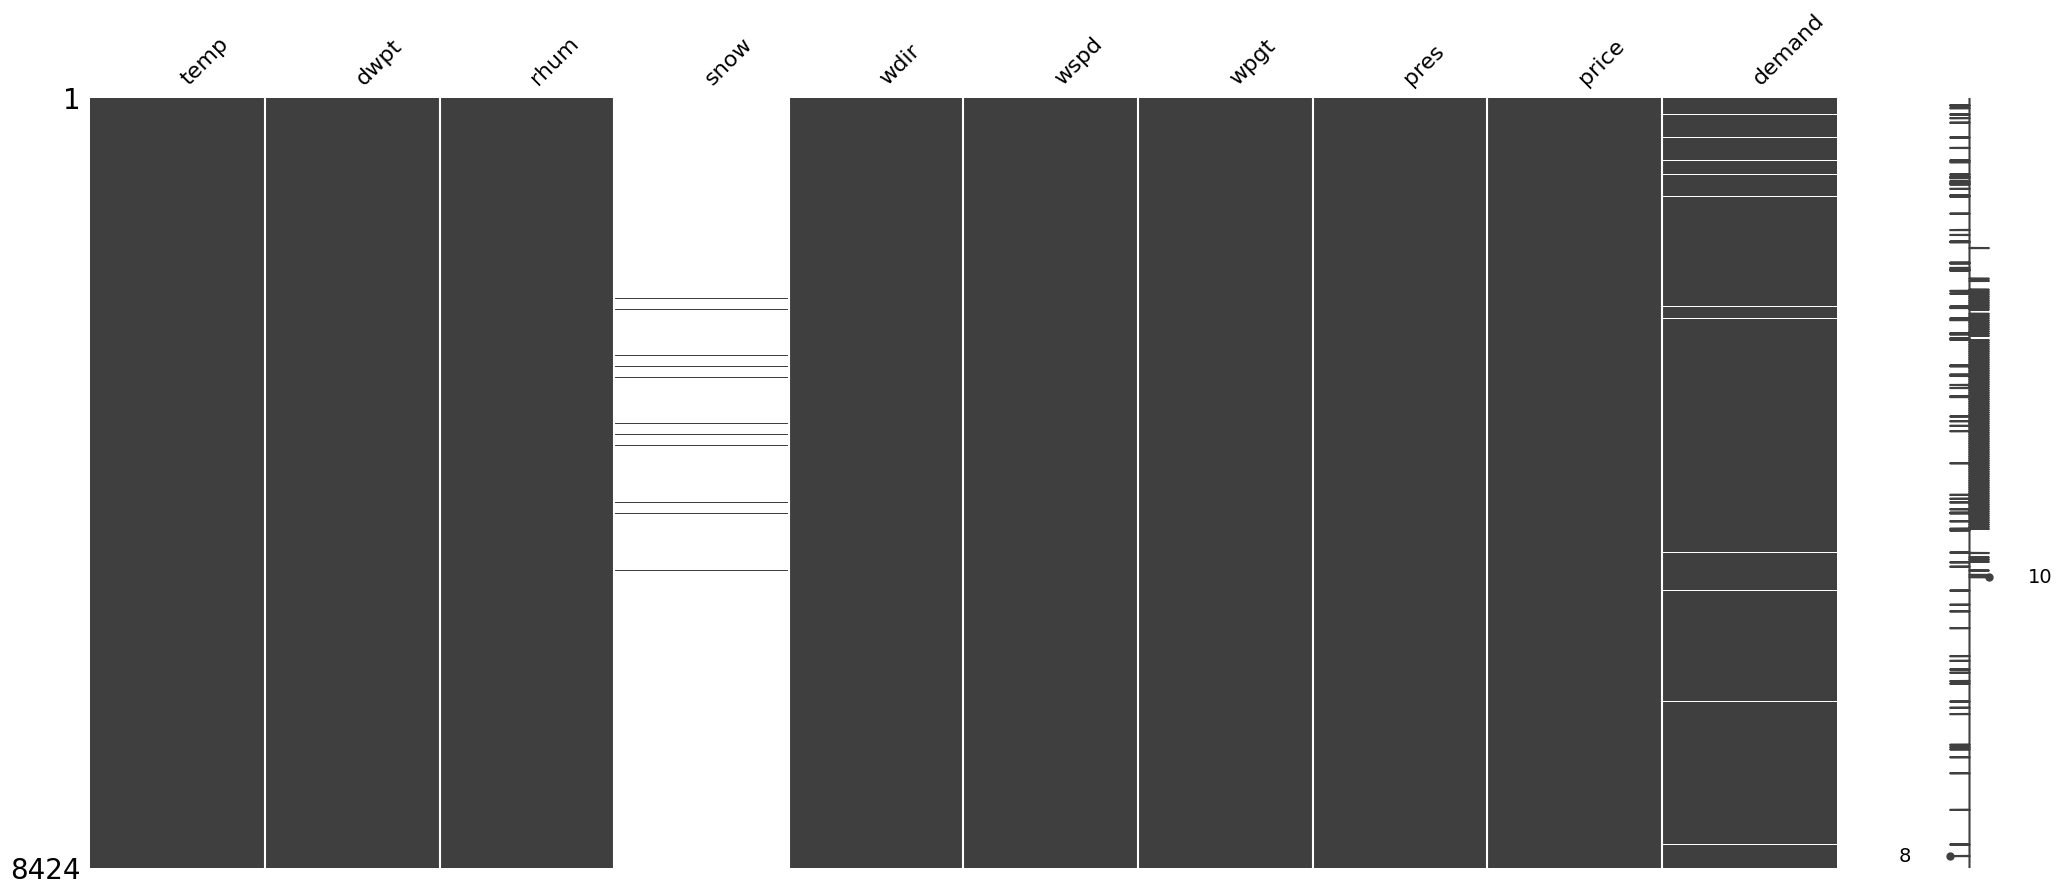

In [ ]:
# %%

msno.matrix(train_data)
plt.show()

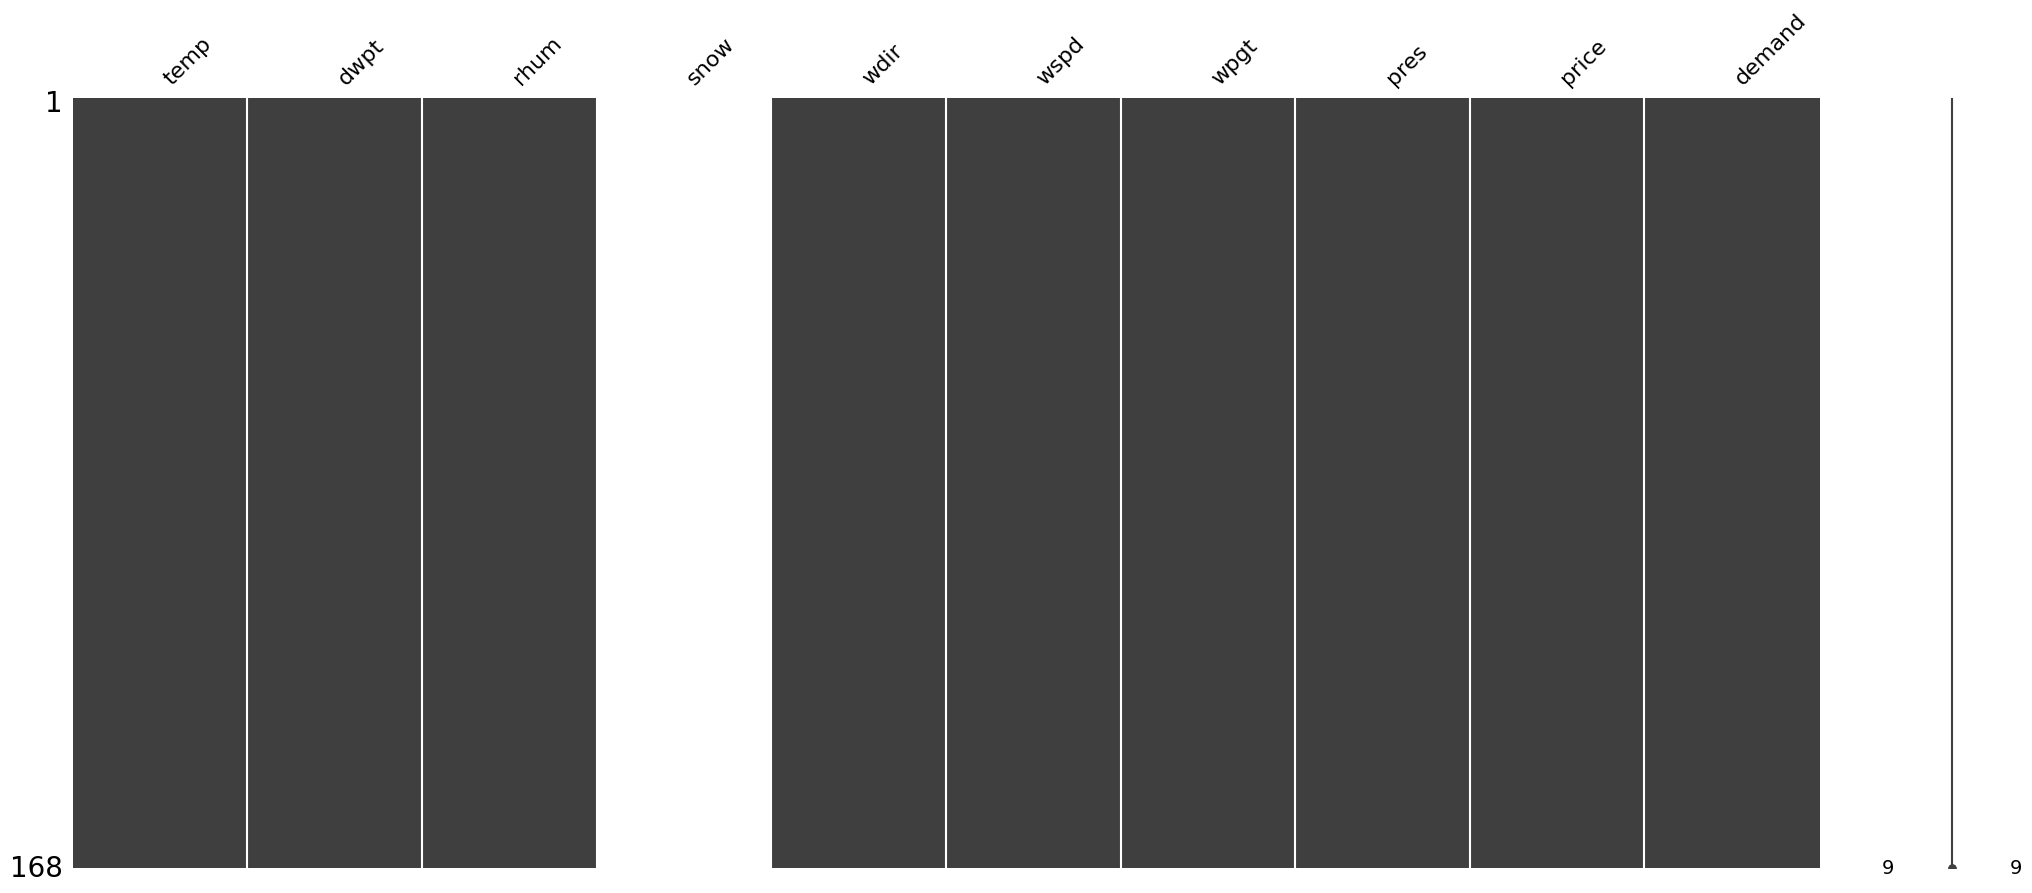

In [ ]:
# %%

msno.matrix(test_data)
plt.show()

In [ ]:
# %%

missing_values = train_data.isnull().sum()
missing_values

temp         0
dwpt         0
rhum         0
snow      8305
wdir         0
wspd         0
wpgt         0
pres         0
price        0
demand      86
dtype: int64

In [ ]:
# %%

missing_values = test_data.isnull().sum()
missing_values

temp        0
dwpt        0
rhum        0
snow      168
wdir        0
wspd        0
wpgt        0
pres        0
price       0
demand      0
dtype: int64

In [ ]:
# %%

# Considering snow misses 8305 of 8424 values in train_data, drop it
train_data.drop(columns=["snow"], inplace=True)
test_data.drop(columns=["snow"], inplace=True)

train_data.describe()

,temp,dwpt,rhum,wdir,wspd,wpgt,pres,price,demand
count,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8338.000000
mean,6.435708,2.228359,77.191121,202.886633,9.132918,20.931588,1013.128063,0.156541,1.055267
std,9.064983,8.053260,17.482734,87.841014,4.808481,10.003438,12.693745,0.112922,1.105235
min,-26.100000,-28.700000,20.000000,0.000000,0.000000,2.900000,962.600000,0.000070,0.000000
25%,0.300000,-3.000000,66.000000,160.000000,7.200000,13.000000,1006.275000,0.092667,0.367000
50%,6.000000,1.700000,83.000000,210.000000,7.200000,19.100000,1014.400000,0.135120,0.819500
75%,12.800000,8.400000,91.000000,270.000000,10.800000,27.800000,1020.800000,0.198222,1.372000
max,31.400000,20.900000,100.000000,360.000000,31.700000,63.000000,1047.500000,4.000000,10.381000


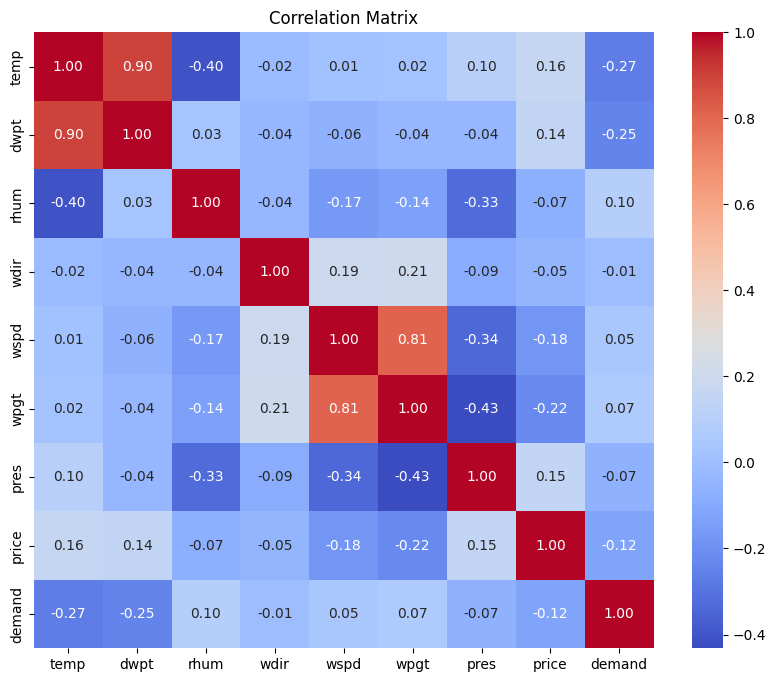

In [ ]:
# %%

plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# %%

# Considering demand misses 86 of 8424 values in train_data
# and there is no straighforward correlation with other features
# possibly MCAR
# evaluate different simple imputation methods

train_data_with_missing = train_data.copy()

# Create a random mask for 10% missing values
np.random.seed(42)
mask = np.random.rand(len(train_data)) < 0.1
true_demand = train_data.loc[mask, "demand"]  # Save true values
train_data_with_missing.loc[mask, "demand"] = np.nan  # Introduce missingness


def impute_and_evaluate(train_data_with_missing, true_demand, method):
    imputed_data = train_data_with_missing.copy()

    if method == "linear":
        imputed_data["demand"] = imputed_data["demand"].interpolate(method=method)
    elif method == "spline":
        imputed_data["demand"] = imputed_data["demand"].interpolate(
            method=method, order=2
        )
    elif method == "ffill_bfill":
        imputed_data["demand"] = imputed_data["demand"].ffill().bfill()
    else:
        raise ValueError(f"Unsupported method: {method}")

    # Extract imputed values and compare with true values
    imputed_values = imputed_data.loc[mask, "demand"]
    combined = pd.DataFrame({"true": true_demand, "imputed": imputed_values}).dropna()

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(combined["true"], combined["imputed"]))
    mae = mean_absolute_error(combined["true"], combined["imputed"])
    return f"{method.capitalize()} - RMSE: {rmse:.4f}, MAE: {mae:.4f}"


methods = ["linear", "spline", "ffill_bfill"]

for method in methods:
    result = impute_and_evaluate(train_data_with_missing, true_demand, method)
    print(result)

Linear - RMSE: 0.6320, MAE: 0.4218
Spline - RMSE: 0.8105, MAE: 0.5650
Ffill_bfill - RMSE: 0.8657, MAE: 0.5174


In [ ]:
# %%

# Considering linear imputation performs best, apply it to train_data
# Linear - RMSE: 0.6320, MAE: 0.4218
# Spline - RMSE: 0.8105, MAE: 0.5650
# Ffill_bfill - RMSE: 0.8657, MAE: 0.5174
train_data["demand"] = train_data["demand"].interpolate(method="linear")

In [ ]:
# %%

train_data

,temp,dwpt,rhum,wdir,wspd,wpgt,pres,price,demand
time,,,,,,,,,
2021-08-31 21:00:00+00:00,11.2,10.3,94.0,320.0,7.2,16.7,1012.6,0.09016,0.577
2021-08-31 22:00:00+00:00,10.7,9.6,93.0,320.0,7.2,13.0,1012.6,0.09251,0.594
2021-08-31 23:00:00+00:00,9.9,9.0,94.0,320.0,7.2,13.0,1012.2,0.08890,0.685
2021-09-01 00:00:00+00:00,10.0,8.4,90.0,330.0,7.2,13.0,1011.9,0.08735,1.016
2021-09-01 01:00:00+00:00,9.0,8.1,94.0,300.0,3.6,13.0,1011.4,0.08688,0.677
...,...,...,...,...,...,...,...,...,...
2022-08-17 16:00:00+00:00,26.1,16.1,54.0,120.0,7.0,13.0,1015.0,0.75008,0.897
2022-08-17 17:00:00+00:00,24.1,16.1,61.0,100.0,6.0,14.8,1015.0,0.75005,2.796
2022-08-17 18:00:00+00:00,24.1,16.6,63.0,90.0,4.0,13.0,1015.5,0.74888,0.733


In [ ]:
# %%

# Save cleaned train and test data
train_data.to_csv("data/train_data_cleaned.csv", index=True)
test_data.to_csv("data/test_data_cleaned.csv", index=True)
train_data.describe()

,temp,dwpt,rhum,wdir,wspd,wpgt,pres,price,demand
count,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000
mean,6.435708,2.228359,77.191121,202.886633,9.132918,20.931588,1013.128063,0.156541,1.054433
std,9.064983,8.053260,17.482734,87.841014,4.808481,10.003438,12.693745,0.112922,1.101446
min,-26.100000,-28.700000,20.000000,0.000000,0.000000,2.900000,962.600000,0.000070,0.000000
25%,0.300000,-3.000000,66.000000,160.000000,7.200000,13.000000,1006.275000,0.092667,0.367750
50%,6.000000,1.700000,83.000000,210.000000,7.200000,19.100000,1014.400000,0.135120,0.822000
75%,12.800000,8.400000,91.000000,270.000000,10.800000,27.800000,1020.800000,0.198222,1.369000
max,31.400000,20.900000,100.000000,360.000000,31.700000,63.000000,1047.500000,4.000000,10.381000


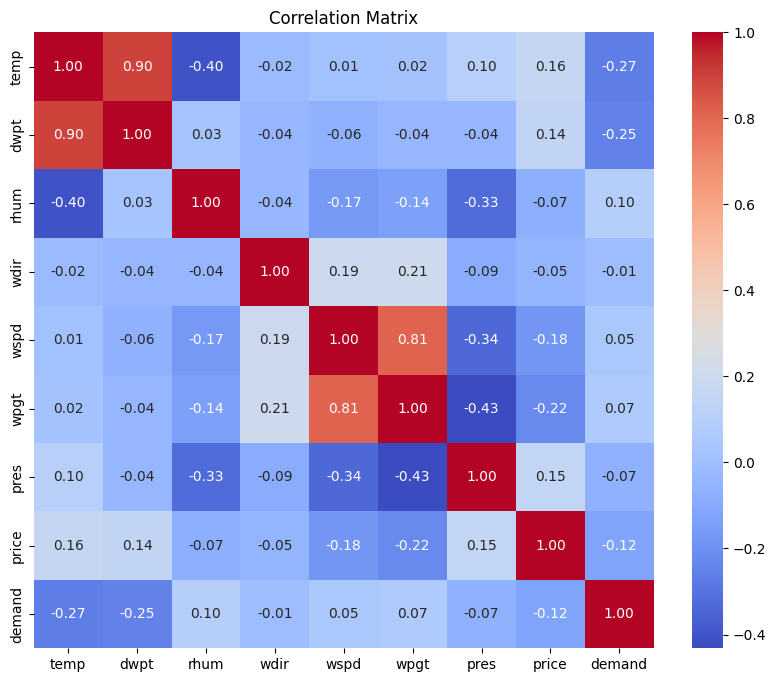

In [ ]:
# %%

# Visualization 1: Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

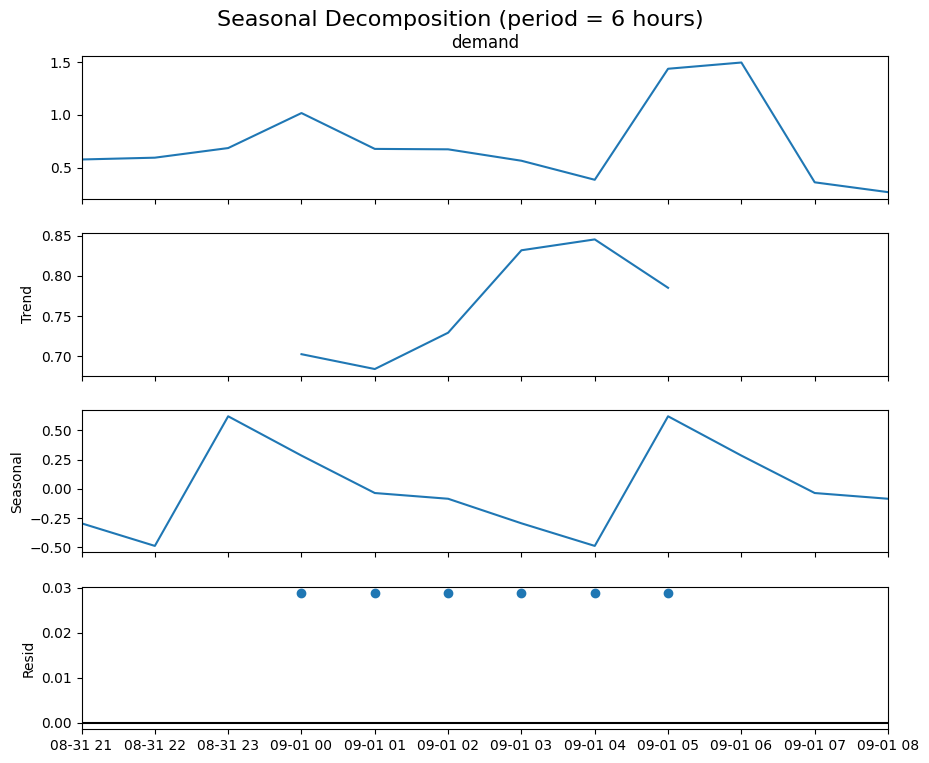

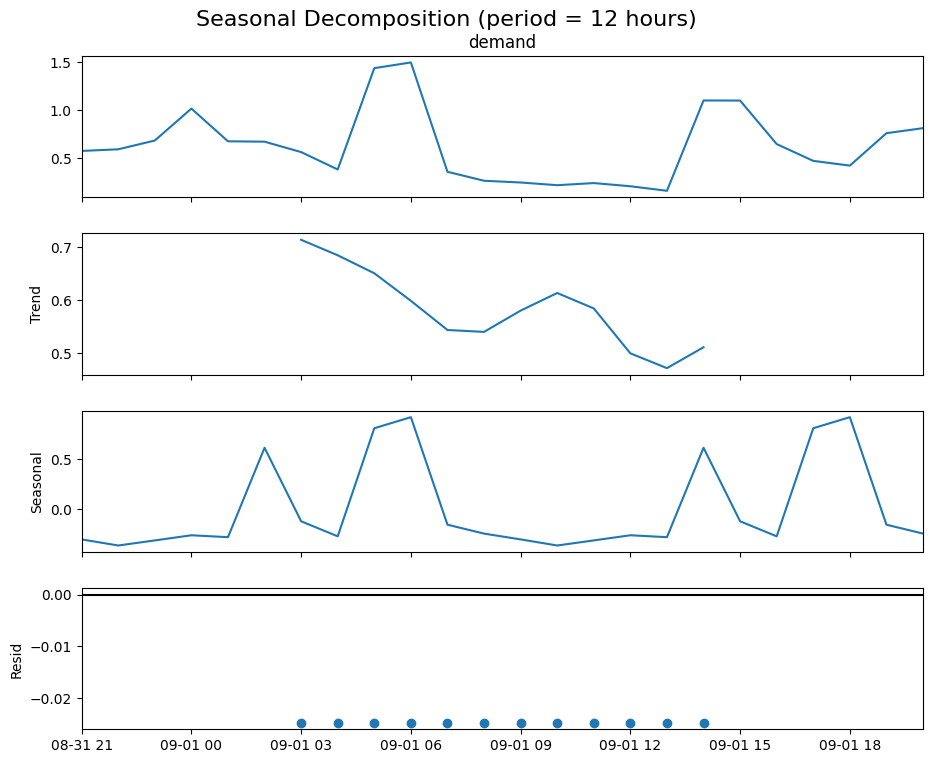

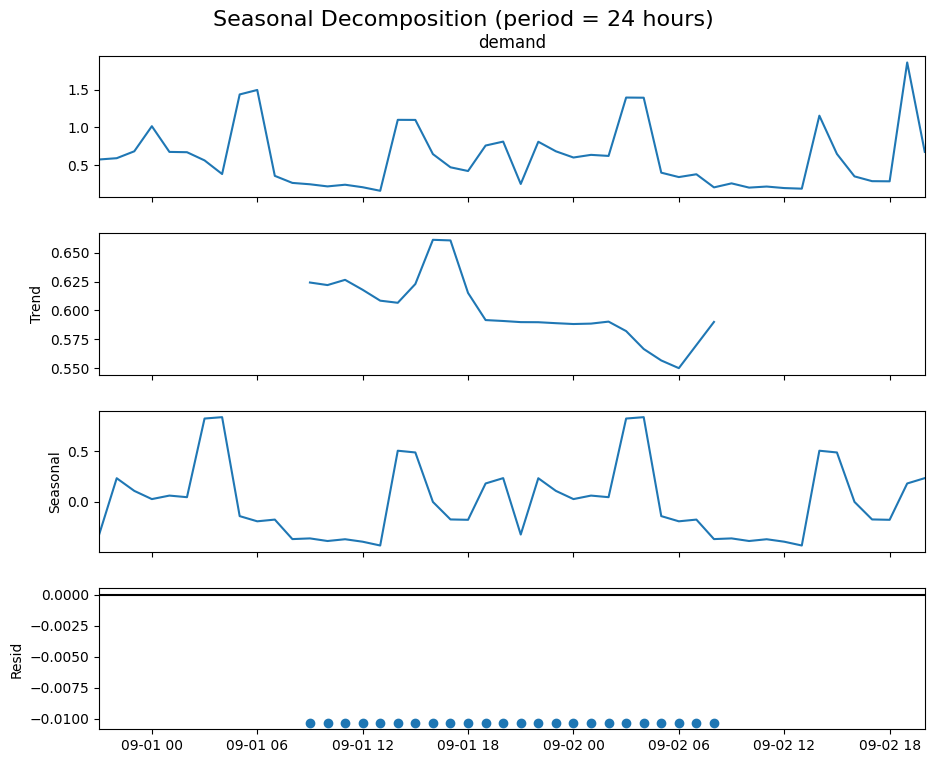

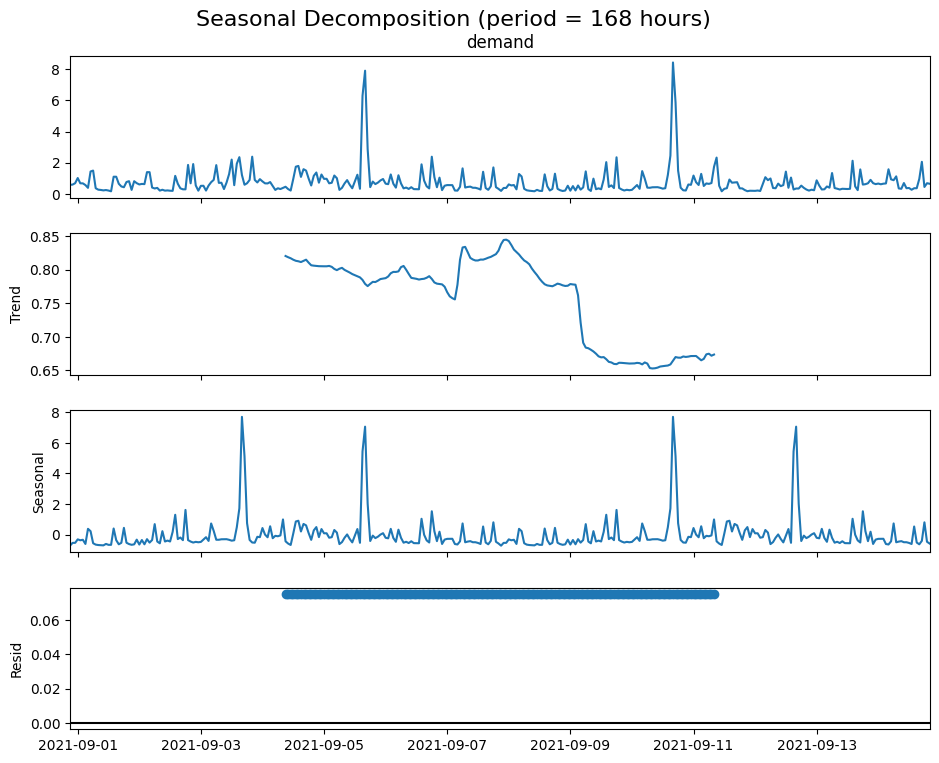

In [ ]:
# %%

# Visualization 2: Seasonal decomposition
# Testing decomposition with different periods to find the optimal one
# 24 hours (daily), 168 hours (weekly)

periods = [6, 12, 24, 7 * 24]

for period in periods:
    decomposition = seasonal_decompose(
        train_data["demand"][: 2 * period], model="additive", period=period
    )
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.suptitle(
        f"Seasonal Decomposition (period = {period} hours)",
        fontsize=16,
    )
    plt.show()

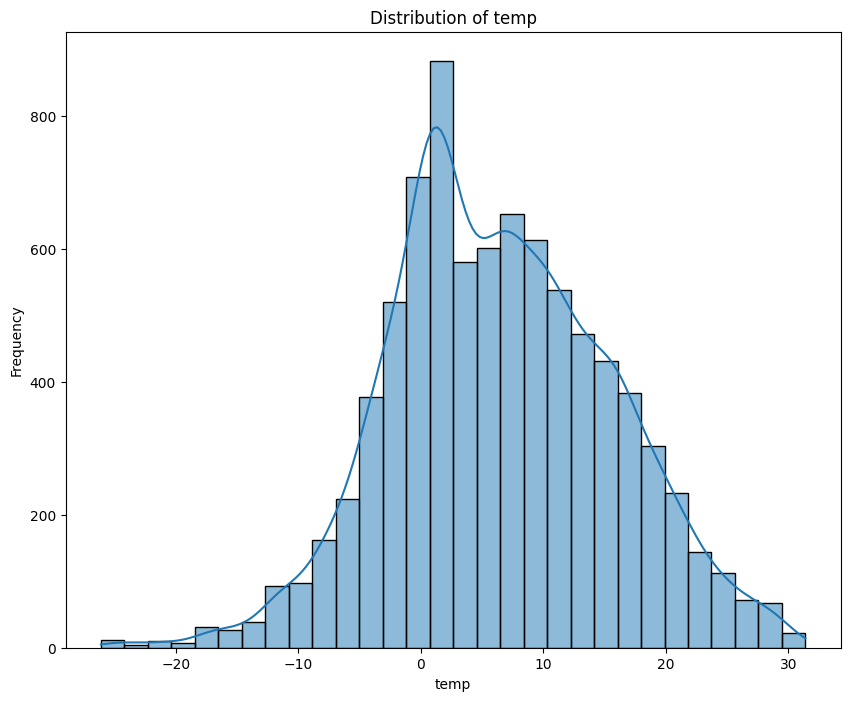

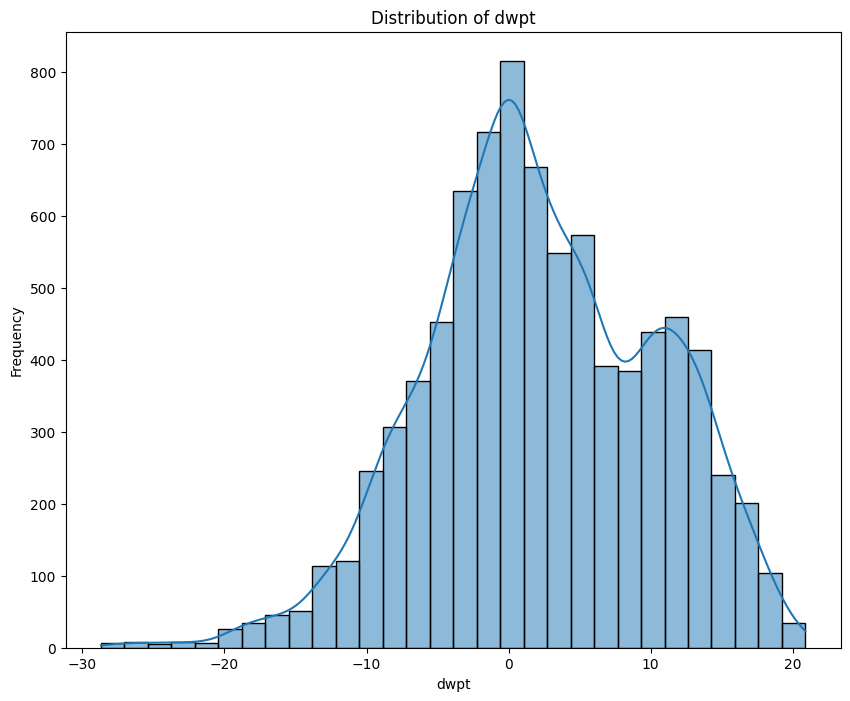

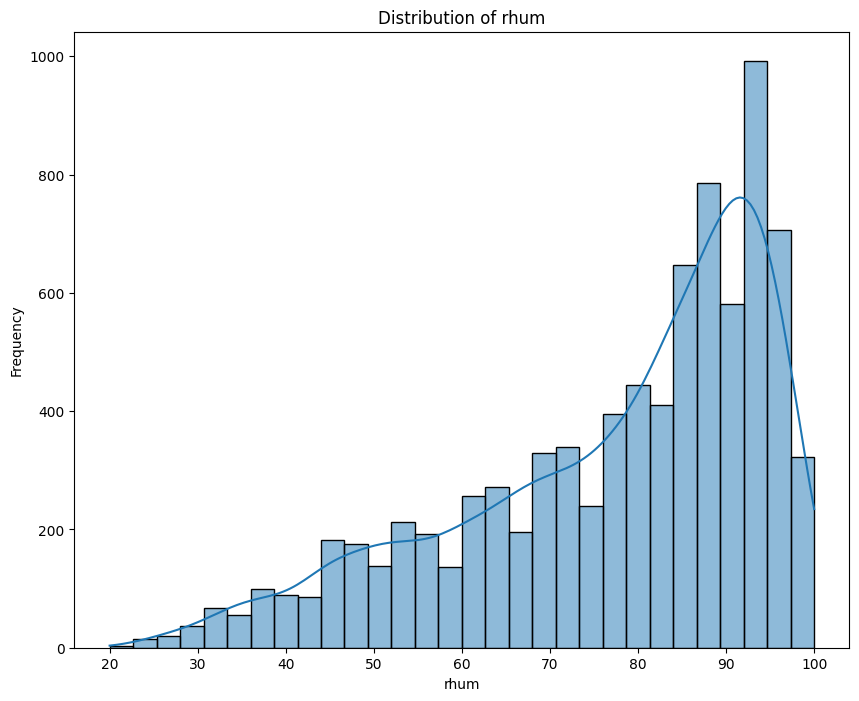

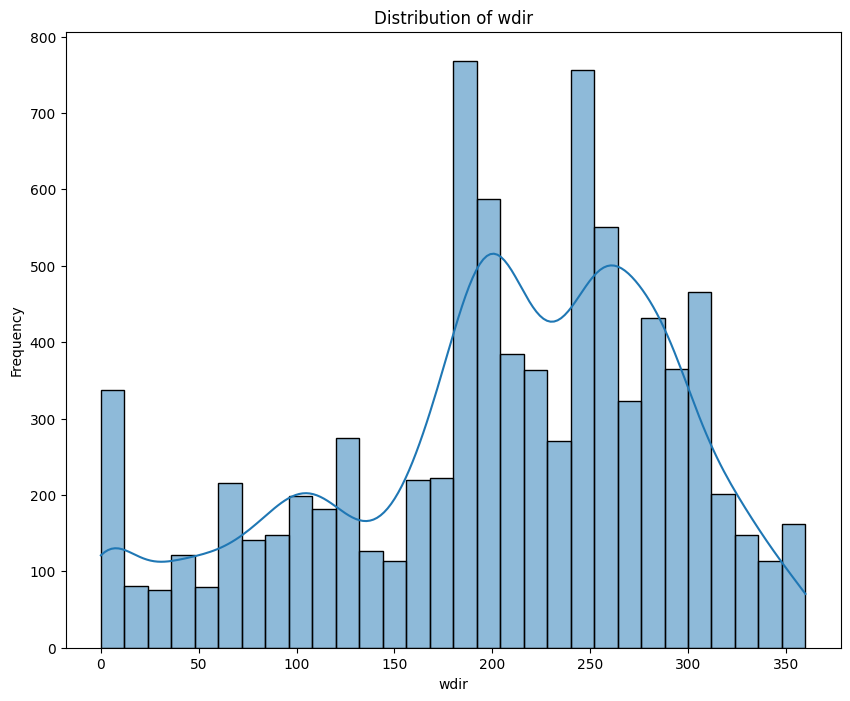

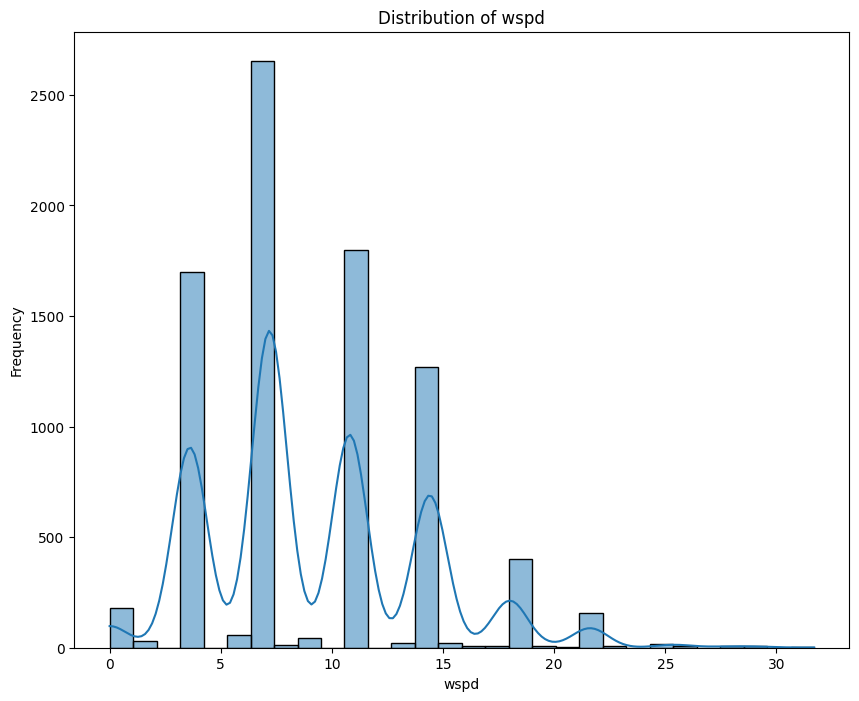

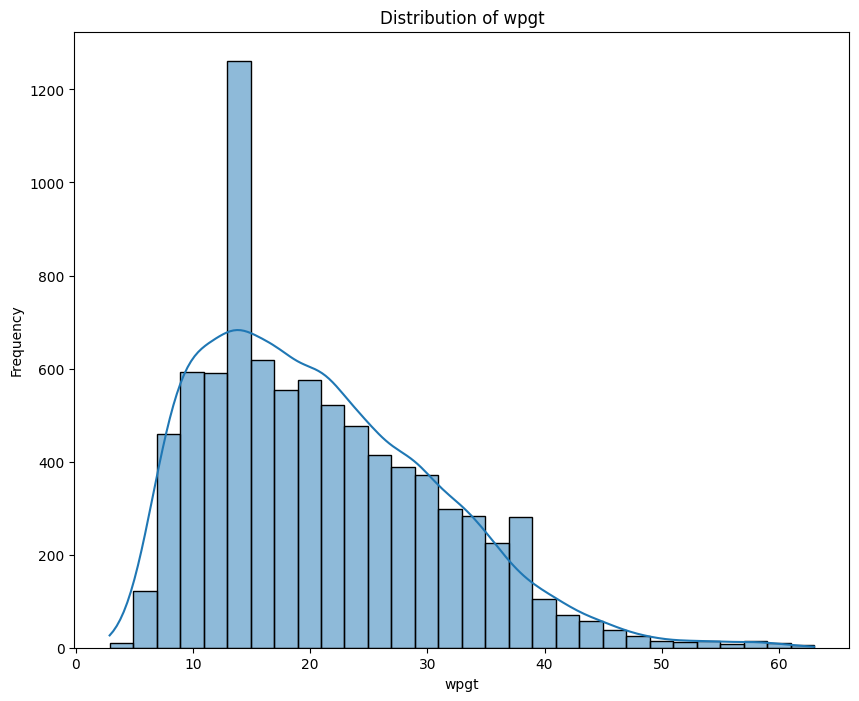

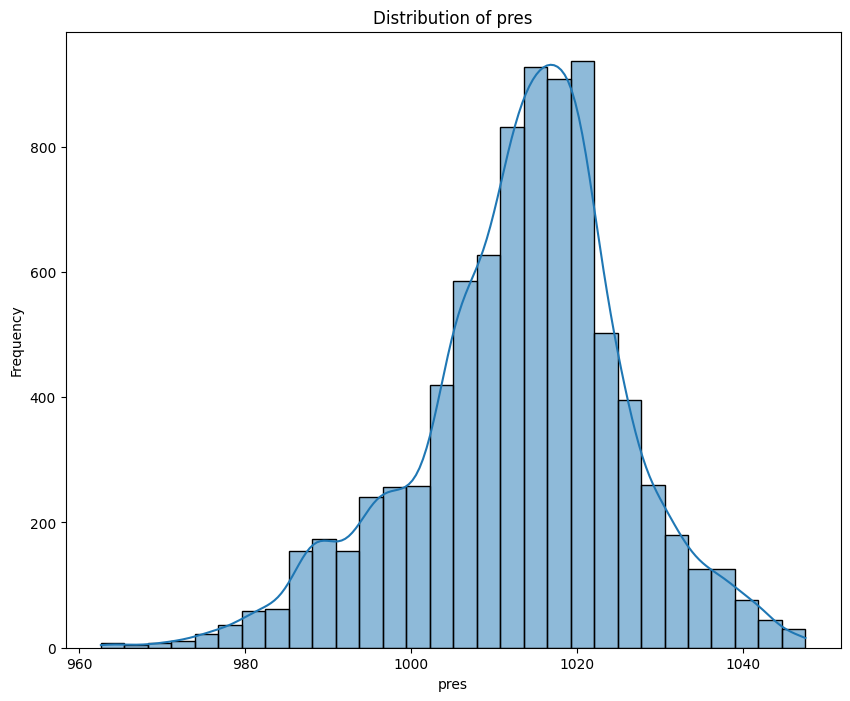

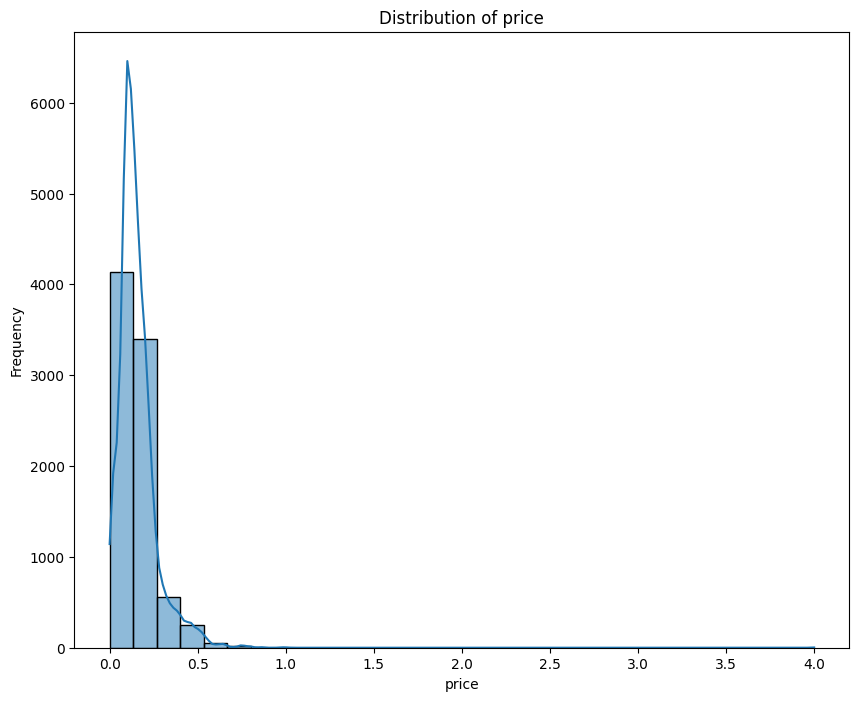

Skewness of temp: 0.0588
Skewness of dwpt: -0.1420
Skewness of rhum: -0.9020
Skewness of wdir: -0.5887
Skewness of wspd: 0.6829
Skewness of wpgt: 0.7630
Skewness of pres: -0.4476
Skewness of price: 6.1581


In [ ]:
# %%

# Analyze distributions of numerical features
numerical_features = train_data.select_dtypes(include=np.number).columns.drop("demand")

for feature in numerical_features:
    plt.figure(figsize=(10, 8))
    sns.histplot(train_data[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

for feature in numerical_features:
    print(f"Skewness of {feature}: {train_data[feature].skew():.4f}")

# Skewness of temp: 0.0588
# Skewness of dwpt: -0.1420
# Skewness of rhum: -0.9020
# Skewness of wdir: -0.5887
# Skewness of wspd: 0.6829
# Skewness of wpgt: 0.7630
# Skewness of pres: -0.4476
# Skewness of price: 6.1581
# Seems like price is skewed and wspd is multimodal
# Also wdir can be sin-cos transformed

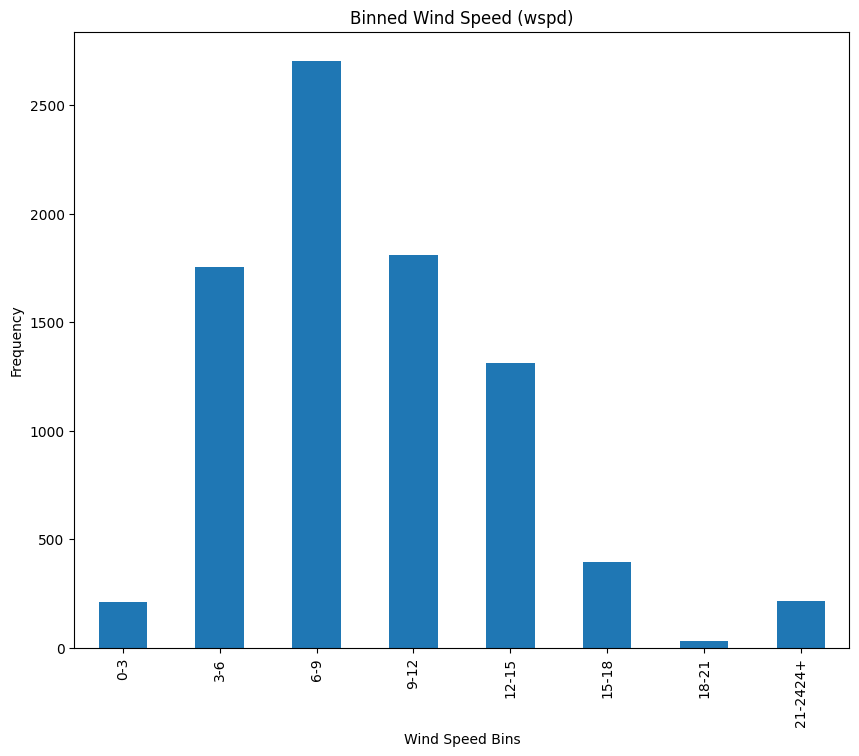

In [ ]:
# %% Binning wspd

train_data_copy = train_data.copy()


def bin_feature(data, feature, bins, labels):
    return pd.cut(data[feature], bins=bins, labels=labels, include_lowest=True)


wspd_bins = [0, 3, 6, 9, 12, 15, 18, 21, np.inf]
wspd_labels = ["0-3", "3-6", "6-9", "9-12", "12-15", "15-18", "18-21", "21-24" "24+"]

train_data_copy["wspd_binned"] = bin_feature(train_data, "wspd", wspd_bins, wspd_labels)

plt.figure(figsize=(10, 8))
train_data_copy["wspd_binned"].value_counts().sort_index().plot(kind="bar")
plt.title("Binned Wind Speed (wspd)")
plt.xlabel("Wind Speed Bins")
plt.ylabel("Frequency")
plt.show()

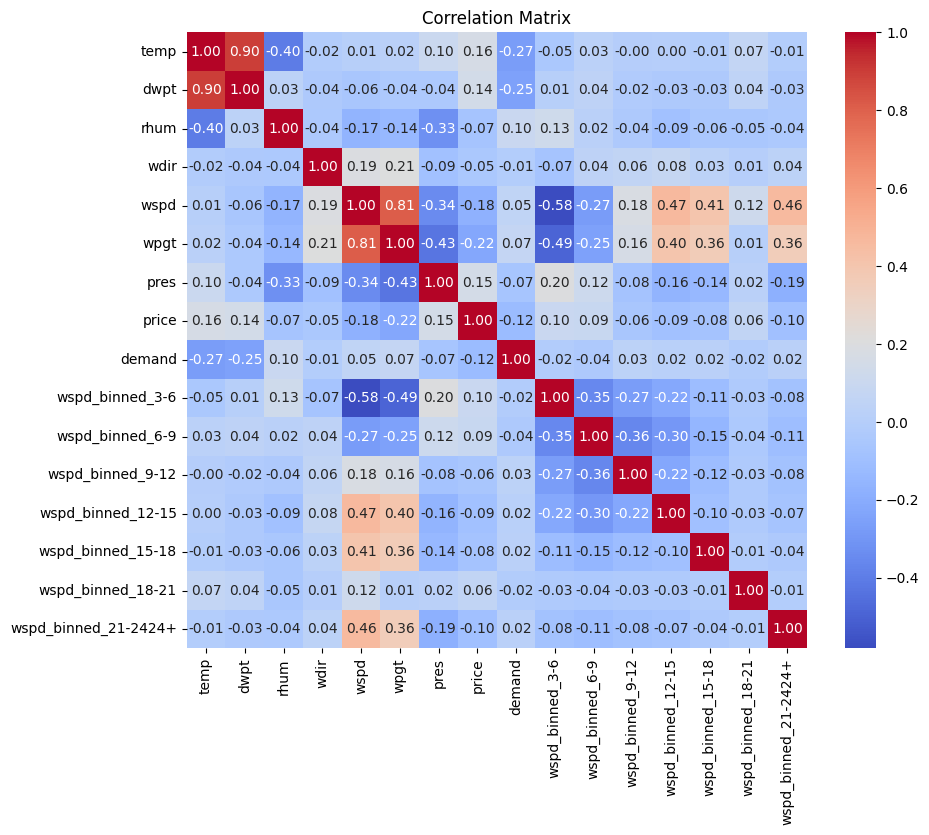

In [ ]:
# %% Correlation Matrix of Transformed Features

plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.get_dummies(train_data_copy, drop_first=True).corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
)
plt.title("Correlation Matrix")
plt.show()

# From examining correlation matrix, it seems that binned wspd is not reasonable to use

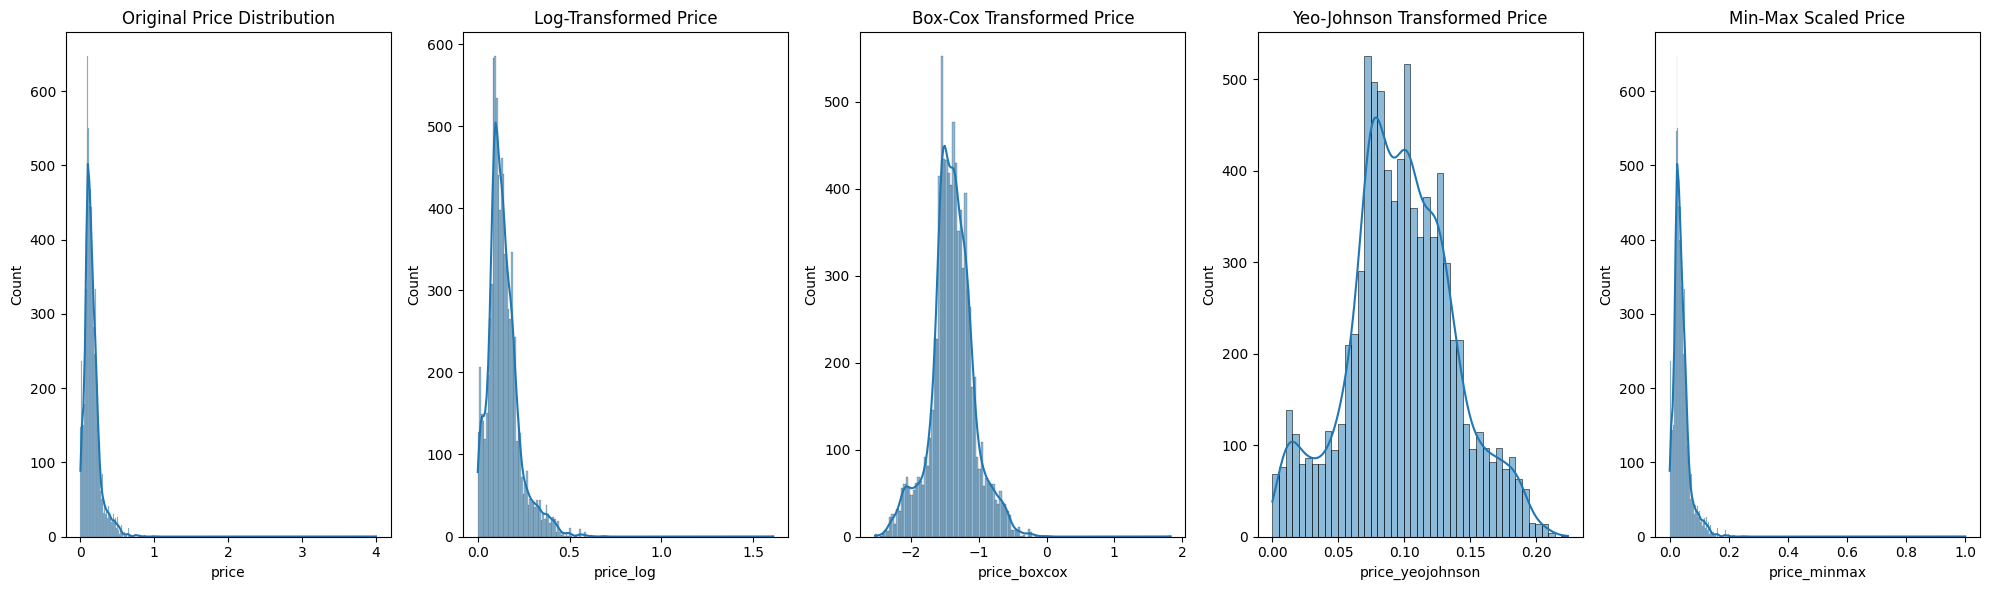

In [ ]:
# %% Compare transformations for price

# Ensure price is positive for Box-Cox transformation
train_data_copy = train_data.copy()

price_positive = train_data_copy["price"] + 1e-6

train_data_copy["price_log"] = np.log1p(train_data_copy["price"])  # Log Transformation
train_data_copy["price_boxcox"], _ = boxcox(price_positive)  # Box-Cox Transformation
train_data_copy["price_yeojohnson"], _ = yeojohnson(
    train_data_copy["price"]
)  # Yeo-Johnson Transformation
scaler = MinMaxScaler()
train_data_copy["price_minmax"] = scaler.fit_transform(
    train_data_copy[["price"]]
)  # Min-Max Scaling

fig, axes = plt.subplots(1, 5, figsize=(20, 6))

sns.histplot(train_data_copy["price"], kde=True, ax=axes[0])
axes[0].set_title("Original Price Distribution")

sns.histplot(train_data_copy["price_log"], kde=True, ax=axes[1])
axes[1].set_title("Log-Transformed Price")

sns.histplot(train_data_copy["price_boxcox"], kde=True, ax=axes[2])
axes[2].set_title("Box-Cox Transformed Price")

sns.histplot(train_data_copy["price_yeojohnson"], kde=True, ax=axes[3])
axes[3].set_title("Yeo-Johnson Transformed Price")

sns.histplot(train_data_copy["price_minmax"], kde=True, ax=axes[4])
axes[4].set_title("Min-Max Scaled Price")

plt.tight_layout()
plt.show()

In [ ]:
# %% Compare skewness

original_skew = train_data_copy["price"].skew()
log_skew = train_data_copy["price_log"].skew()
boxcox_skew = pd.Series(train_data_copy["price_boxcox"]).skew()
yeojohnson_skew = pd.Series(train_data_copy["price_yeojohnson"]).skew()
minmax_skew = pd.Series(train_data_copy["price_minmax"]).skew()

print(f"Original Price Skewness: {original_skew:.4f}")
print(f"Log-Transformed Price Skewness: {log_skew:.4f}")
print(f"Box-Cox Transformed Price Skewness: {boxcox_skew:.4f}")
print(f"Yeo-Johnson Transformed Skewness: {yeojohnson_skew:.4f}")
print(f"Min-Max Scaled Price Skewness: {minmax_skew:.4f}")

# Original Price Skewness: 6.1581
# Log-Transformed Price Skewness: 1.8920
# Box-Cox Transformed Price Skewness: 0.1347
# Yeo-Johnson Transformed Skewness: 0.0165
# Min-Max Scaled Price Skewness: 6.1581
# Seems like Yeo-Johnson transformation is the best for price, Box-Cox also introduces negative values

Original Price Skewness: 6.1581
Log-Transformed Price Skewness: 1.8920
Box-Cox Transformed Price Skewness: 0.1347
Yeo-Johnson Transformed Skewness: 0.0165
Min-Max Scaled Price Skewness: 6.1581


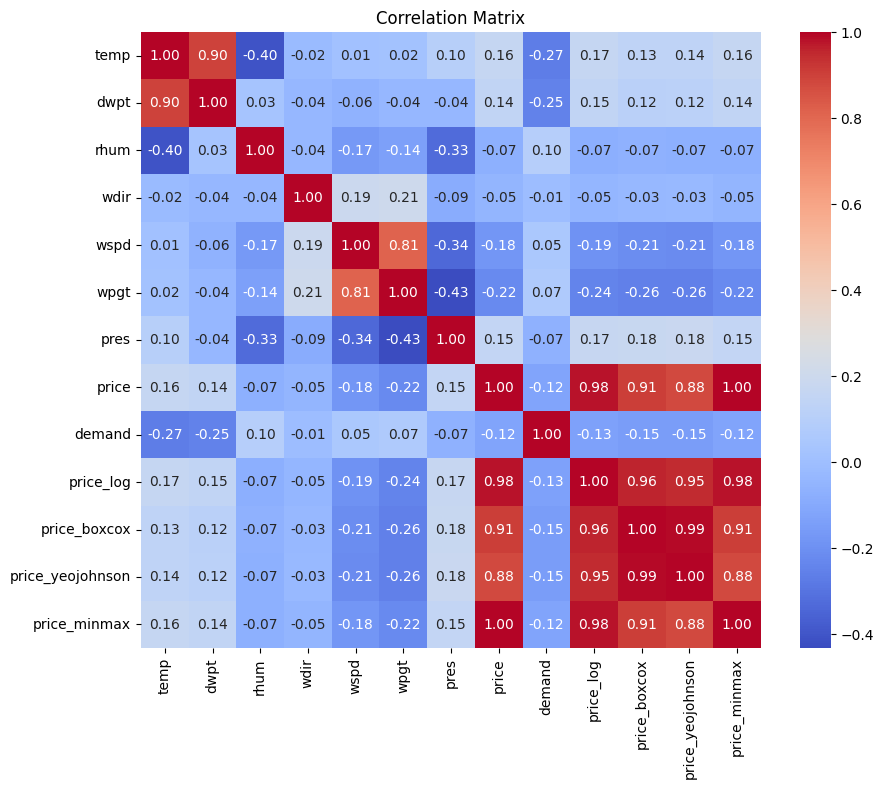

In [ ]:
# %% Correlation Matrix of Transformed Features

plt.figure(figsize=(10, 8))
sns.heatmap(train_data_copy.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

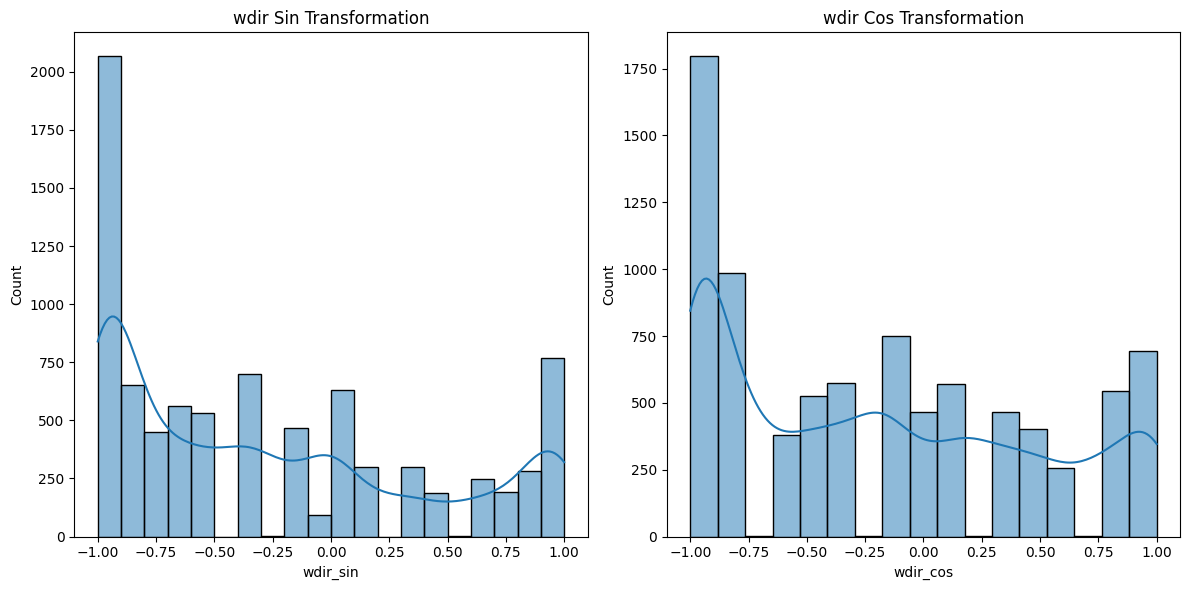

In [ ]:
# %% Sin-Cos Transformation for wdir

train_data_copy = train_data.copy()

train_data_copy["wdir_sin"] = np.sin(np.deg2rad(train_data_copy["wdir"]))
train_data_copy["wdir_cos"] = np.cos(np.deg2rad(train_data_copy["wdir"]))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(train_data_copy["wdir_sin"], kde=True, ax=ax[0])
ax[0].set_title("wdir Sin Transformation")
sns.histplot(train_data_copy["wdir_cos"], kde=True, ax=ax[1])
ax[1].set_title("wdir Cos Transformation")

plt.tight_layout()
plt.show()

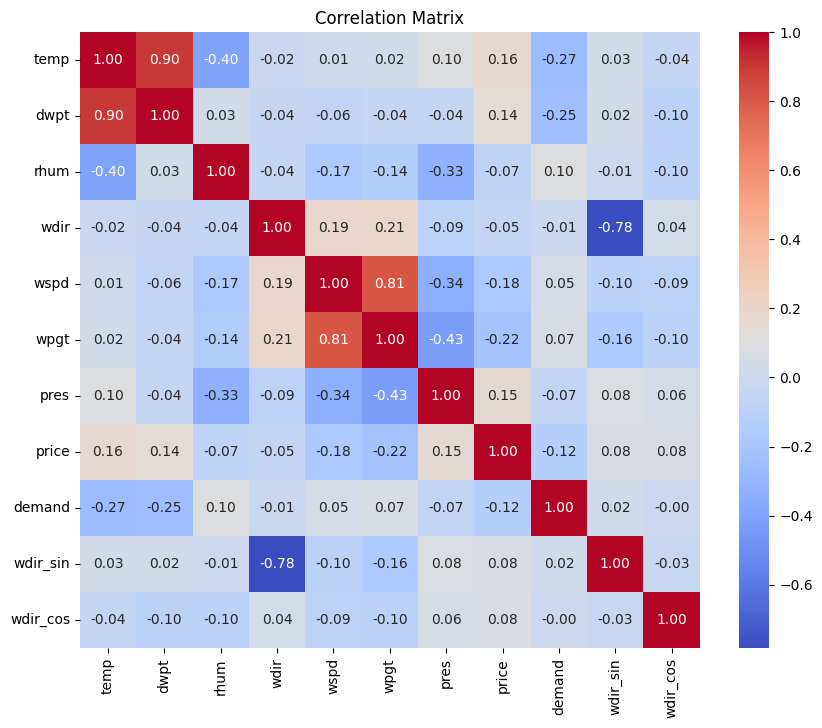

In [ ]:
# %% Correlation Matrix of Transformed Features

plt.figure(figsize=(10, 8))
sns.heatmap(train_data_copy.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# %% Design New Features

train_data_copy = train_data.copy()

# Interaction Features
train_data_copy["temp_rhum_interaction"] = (
    train_data_copy["temp"] * train_data_copy["rhum"]
)
train_data_copy["wspd_wpgt_interaction"] = (
    train_data_copy["wspd"] * train_data_copy["wpgt"]
)
train_data_copy["wspd_temp_interaction"] = (
    train_data_copy["wspd"] * train_data_copy["temp"]
)
train_data_copy["temp_pres_ratio"] = train_data_copy["temp"] / (
    train_data_copy["pres"] + 1e-6
)

# Extract time-based features
train_data_copy["hour"] = train_data_copy.index.hour
train_data_copy["dayofweek"] = train_data_copy.index.dayofweek
train_data_copy["month"] = train_data_copy.index.month

train_data_copy["hourly_price_interaction"] = (
    train_data_copy["hour"] * train_data_copy["price"]
)

# Lag Features
lags = [1, 2, 3, 24]  # Lags for hours and previous day

for lag in lags:
    train_data_copy[f"price_lag_{lag}"] = train_data_copy["price"].shift(lag)
    train_data_copy[f"wspd_lag_{lag}"] = train_data_copy["wspd"].shift(lag)

# Rolling Statistics
# Rolling statistics for price
train_data_copy["price_rolling_mean_24"] = (
    train_data_copy["price"].rolling(window=24).mean()
)
train_data_copy["price_rolling_std_24"] = (
    train_data_copy["price"].rolling(window=24).std()
)

# Rolling statistics for wind speed and wind gust
train_data_copy["wspd_rolling_mean_6"] = (
    train_data_copy["wspd"].rolling(window=6).mean()
)
train_data_copy["wpgt_rolling_max_6"] = train_data_copy["wpgt"].rolling(window=6).max()

# Drop NaN Rows Created by Lags and Rolling Features
train_data_copy = train_data_copy.dropna()

In [ ]:
# %% Display updated train_data_copy with new features

train_data_copy.head()

,temp,dwpt,rhum,wdir,wspd,wpgt,pres,price,demand,temp_rhum_interaction,...,price_lag_2,wspd_lag_2,price_lag_3,wspd_lag_3,price_lag_24,wspd_lag_24,price_rolling_mean_24,price_rolling_std_24,wspd_rolling_mean_6,wpgt_rolling_max_6
time,,,,,,,,,,,,,,,,,,,,,
2021-09-01 21:00:00+00:00,9.6,5.6,76.0,330.0,10.8,16.7,1011.4,0.09432,0.254,729.6,...,0.12576,7.2,0.14493,7.2,0.09016,7.2,0.110467,0.019703,9.0,27.8
2021-09-01 22:00:00+00:00,9.2,5.7,79.0,320.0,7.2,16.7,1011.8,0.09699,0.811,726.8,...,0.11439,7.2,0.12576,7.2,0.09251,7.2,0.110654,0.019547,8.4,24.1
2021-09-01 23:00:00+00:00,9.1,6.2,82.0,300.0,7.2,16.7,1012.2,0.09477,0.685,746.2,...,0.09432,10.8,0.11439,7.2,0.08890,7.2,0.110898,0.019298,7.8,22.2
2021-09-02 00:00:00+00:00,8.4,6.0,85.0,310.0,7.2,16.7,1012.5,0.09388,0.603,714.0,...,0.09699,7.2,0.09432,10.8,0.08735,7.2,0.111170,0.018995,7.8,18.5
2021-09-02 01:00:00+00:00,8.0,6.1,88.0,310.0,7.2,16.7,1012.8,0.09225,0.638,704.0,...,0.09477,7.2,0.09699,7.2,0.08688,3.6,0.111394,0.018726,7.8,16.7


In [ ]:
# %% Display ranking

feature_ranking = (
    train_data_copy.corr()["demand"].drop("demand").sort_values(ascending=False)
)

print("Feature Correlation Ranking with Demand:")
print(feature_ranking)

# Top 2 new positively correlated features:
# 1. wspd_rolling_mean_6: 6-hour rolling mean of wind speed (0.0838)
# 2. wspd_lag_3: 3-hour lagged wind speed (0.0823)

# Top 2 new negatively correlated features:
# 1. temp_rhum_interaction: Interaction of temperature and humidity (-0.2754)
# 2. temp_pres_ratio: Temperature-to-pressure ratio (-0.2669)

Feature Correlation Ranking with Demand:
rhum                        0.094952
wspd_rolling_mean_6         0.083824
wspd_lag_3                  0.082309
wspd_lag_2                  0.072944
wpgt                        0.069359
wspd_wpgt_interaction       0.065521
wpgt_rolling_max_6          0.064315
wspd_lag_1                  0.061494
hour                        0.059041
wspd                        0.049783
dayofweek                   0.036320
wspd_lag_24                 0.025666
wdir                       -0.010551
price_rolling_std_24       -0.047457
month                      -0.048853
hourly_price_interaction   -0.054587
price_lag_24               -0.061922
pres                       -0.065454
price_rolling_mean_24      -0.068790
price_lag_3                -0.095120
price_lag_2                -0.100067
price_lag_1                -0.115828
price                      -0.123282
wspd_temp_interaction      -0.190473
dwpt                       -0.247281
temp_pres_ratio            -0.2668

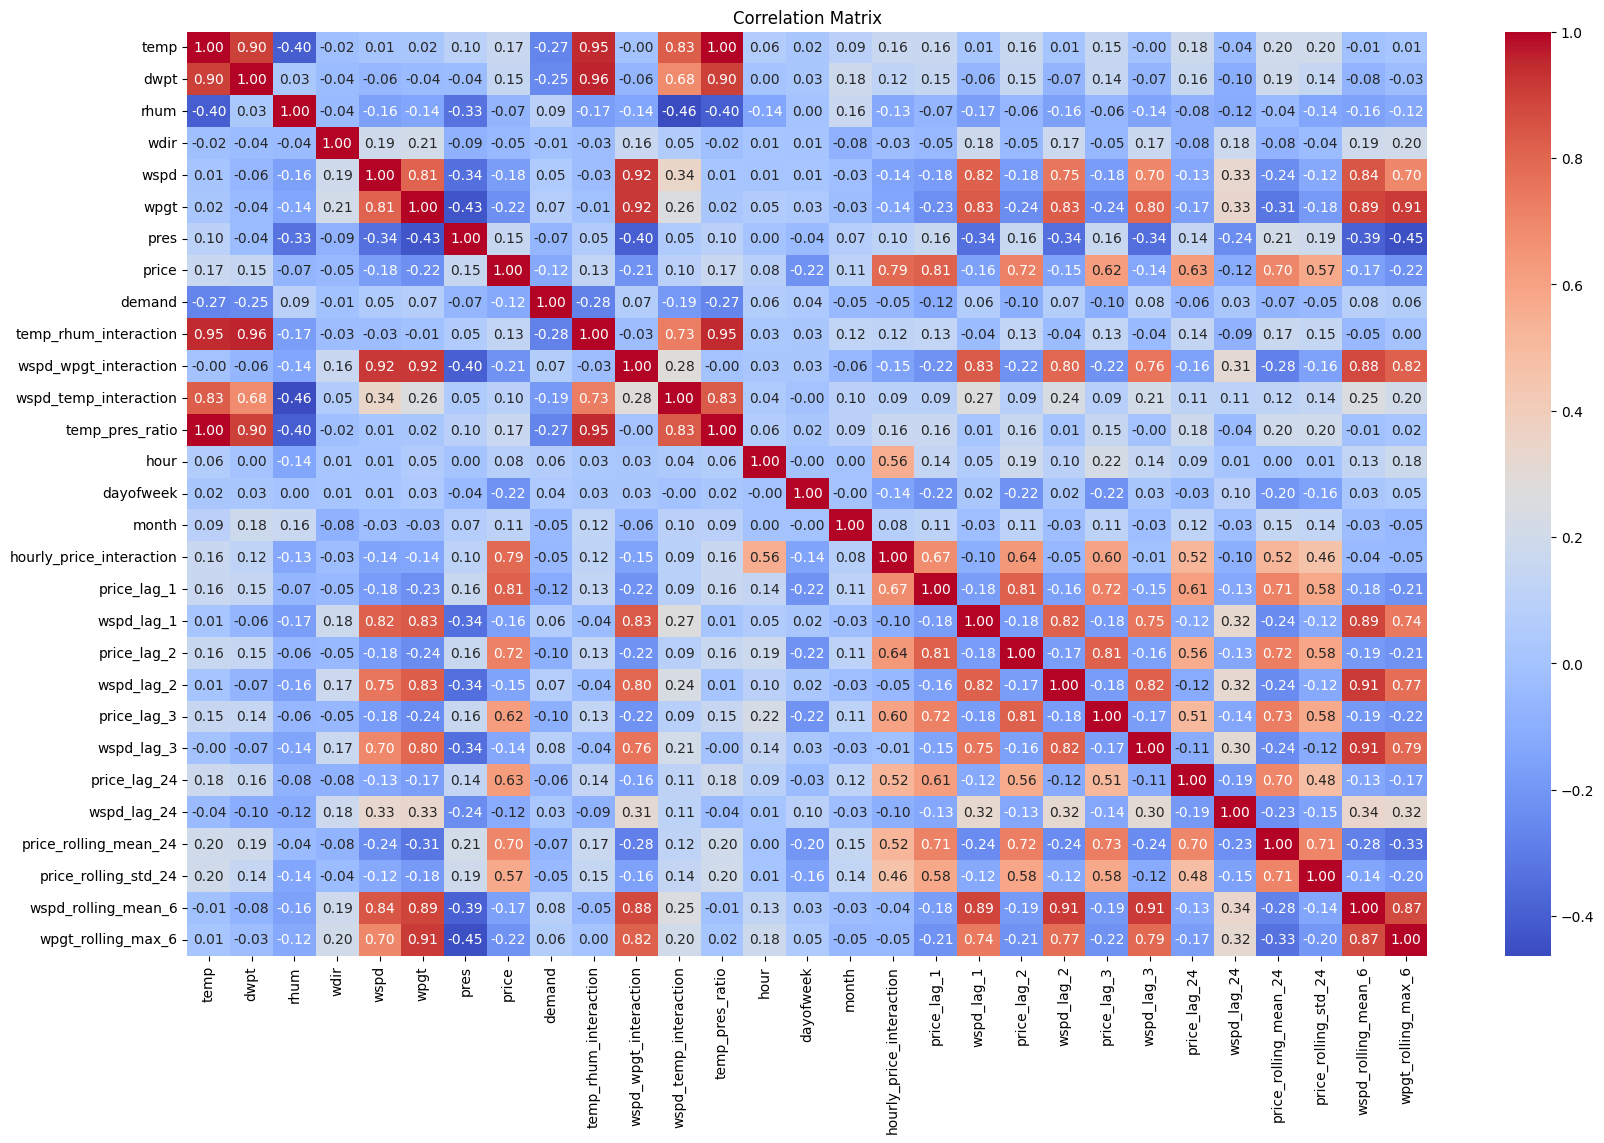

In [ ]:
# %% Correlation Matrix of New Features

plt.figure(figsize=(20, 12))
sns.heatmap(train_data_copy.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# %% Best Feature Engineering Steps

train_data_w_feat = train_data.copy()

# Yeo-Johnson Transformation for price
train_data_w_feat["price_yeojohnson"], _ = yeojohnson(train_data_w_feat["price"])

# Sin-Cos transformation for wind direction (wdir)
train_data_w_feat["wdir_sin"] = np.sin(np.deg2rad(train_data_w_feat["wdir"]))
train_data_w_feat["wdir_cos"] = np.cos(np.deg2rad(train_data_w_feat["wdir"]))

# Interaction Features
train_data_w_feat["temp_rhum_interaction"] = (
    train_data_w_feat["temp"] * train_data_w_feat["rhum"]
)
train_data_w_feat["temp_pres_ratio"] = train_data_w_feat["temp"] / (
    train_data_w_feat["pres"] + 1e-6
)

# Lag Features
train_data_w_feat["wspd_lag_3"] = train_data_w_feat["wspd"].shift(3)

# Rolling Features
train_data_w_feat["wspd_rolling_mean_6"] = (
    train_data_w_feat["wspd"].rolling(window=6).mean()
)

# Drop NaN Rows Created by Lag and Rolling Features
train_data_w_feat = train_data_w_feat.dropna()

# Save the final data with the best new features
# train_data_w_feat.to_csv("data/train_data_w_feat.csv", index=True)